# 古典的手法 
## インポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import random
from PIL import Image
import torch
import torchvision
from torchvision import datasets, models, transforms
import os

## クラス、変数定義

In [2]:
directory_path = "D:/Work/ImageRecognition/Images/%s"
food_path = "food_142/"
flower_path = "flower_142/"
art_path = "art_142/"
balloon_path = "balloon_142/"
food_test_path = "food_test/"
flower_test_path = "flower_test/"
art_test_path = "art_test/"
balloon_test_path = "balloon_test/"

class MultiClassDataset(torch.utils.data.Dataset):

    def __init__(self, contents=["fo", "fl"], transform=None, train=True):
        self.transform = transform
        self.images = []
        self.labels = []
        self.contents_label = []
        for i, c in enumerate(contents):
            if train:
                if c == "fo" or c == "food":
                    folder = directory_path%(food_path)
                elif c == "fl" or c == "flower":
                    folder = directory_path%(flower_path)
                elif c == "a" or c == "art":
                    folder = directory_path%(art_path)
                elif c == "b" or c == "balloon":
                    folder = directory_path%(balloon_path)
                else:
                    raise ValueError(f"{c} は間違った入力です")
            else:
                if c == "fo" or c == "food":
                    folder = directory_path%(food_test_path)
                elif c == "fl" or c == "flower":
                    folder = directory_path%(flower_test_path)
                elif c == "a" or c == "art":
                    folder = directory_path%(art_test_path)
                elif c == "b" or c == "balloon":
                    folder = directory_path%(balloon_test_path)
                else:
                    raise ValueError(f"{c} は間違った入力です")
            self.images.extend([folder + p for p in os.listdir(folder)])
            self.labels.extend([i] * (len(self.images)-len(self.labels)))
            self.contents_label.append(c)
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        with open(image, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.images)
    
    def get_label_names(self):
        return self.contents_label
    
center_transforms = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
    ])

In [3]:
test_contents = ["fo", "fl", "a", "b"]

train_dataset = MultiClassDataset(contents=test_contents, transform=center_transforms, train=True)
test_dataset = MultiClassDataset(contents=test_contents, transform=center_transforms, train=False)
num_classes = len(train_dataset.get_label_names())
print(train_dataset.get_label_names())

train_image = []
train_label = []
test_image = []
test_label = []

for image, label in train_dataset:
    train_image.append(np.array(image))
    train_label.append(label)
    
for image, label in test_dataset:
    test_image.append(np.array(image))
    test_label.append(label)

    
train_image = np.array(train_image)
train_label = np.array(train_label)
test_image = np.array(test_image)
test_label = np.array(test_label)
    

['fo', 'fl', 'a', 'b']


270


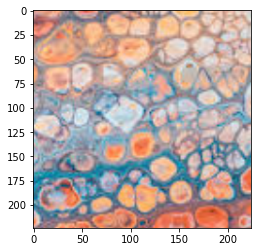

2


In [4]:
data_idx = random.randint(0, len(train_image)-1)
print(data_idx)
plt.imshow(train_image[data_idx])
plt.show()
print(train_label[data_idx])

## 学習

In [5]:
akaze_obj = cv2.AKAZE_create()

debug_kp = []

features_list = []
for idx, x_image in enumerate(train_image):
    # 画像をグレイスケールに変換する
    gray = cv2.cvtColor(x_image, cv2.COLOR_BGR2GRAY)
    
    # AKAZEで検出＋記述
    ## keypoints: キーポイントの位置・方向等の情報（分類では使わない）
    ## features：　キーポイント上の画像特徴量 (検出したKeyPointの数 x 128次元)
    keypoints, features = akaze_obj.detectAndCompute(gray, None)

    debug_kp.append(keypoints)
    
    # SIFTの特徴量をリストに追加していく
    features_list.append(features)
    
    # どんなKey Pointを取り出したか確認してみる
    if idx is data_idx:
        kp_img = cv2.drawKeypoints(x_image, keypoints, None)
        plt.imshow(kp_img)

In [6]:
print(features_list[0].shape)

(236, 61)


KMeans(n_clusters=64, random_state=0)

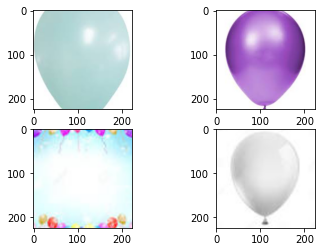

In [7]:
# 学習データの画像特徴量
flat_features_list = []
debug_imglist = []
for i, features in enumerate(features_list):
    try:
        flat_features_list.extend(features)
        #print(features_list[i].shape)
    except TypeError:
        debug_imglist.append((train_image[i], i))
flat_features_list = np.array(flat_features_list)

for i, (img, j) in enumerate(debug_imglist):
    features_list[j] = np.zeros((1, 61))
    plt.subplot(2,2,i+1)
    kp_img = cv2.drawKeypoints(img, debug_kp[j], None)
    plt.imshow(kp_img)
    
# クラスタリングにはKMeansを使う
n_clusters = 64
kmeans_obj = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_obj.fit(flat_features_list)

In [8]:
img_feature_list = []
for features in features_list:
    # 画像毎の処理
    # features: (検出したKeyPointの数 x 128次元)

    # 各KeyPointのfeatureがどのクラスタに所属するかを求める
    #   -> clustsers：　(検出したKeyPointの数 x 1) 
    #        値は所属するクラスタのIDが
    #        IDは、上の.fit()の段階で勝手に決められている
    clusters =  kmeans_obj.predict(features)

    # np.histogramで各クラスタの割当回数（=単語の出現回数)のデータに変換
    hist_data, _ = np.histogram(clusters, bins=n_clusters, range=(0, n_clusters))

    # データをリストに追加
    img_feature_list.append(hist_data)

# Numpy Arrayに変換しておく（この方が扱いやすい）
img_feature_list = np.array(img_feature_list)

In [13]:
lr_model = LogisticRegression(max_iter=300)
lr_model.fit(img_feature_list, train_label)

pred_train = lr_model.predict(img_feature_list)
accuracy_train = sklearn.metrics.accuracy_score(train_label, pred_train)
print(accuracy_train)

0.6675


## テスト

In [14]:
test_features_list = []
for x_image in test_image:
    # 画像をグレイスケールに変換する
    gray = cv2.cvtColor(x_image, cv2.COLOR_BGR2GRAY)
    
    # AKAZEで検出＋記述
    ## keypoints: キーポイントの位置・方向等の情報（分類では使わない）
    ## features：　キーポイント上の画像特徴量 (検出したKeyPointの数 x 128次元)
    keypoints, features = akaze_obj.detectAndCompute(gray, None)

    # AKAZEの特徴量をリストに追加していく
    test_features_list.append(features)

In [15]:
test_img_feature_list = []
for features in test_features_list:
    try:
        clusters =  kmeans_obj.predict(features)
    except ValueError:
        hist_data = np.zeros(n_clusters)
        test_img_feature_list.append(hist_data)
        continue

    # np.histogramで各クラスタの割当回数（=単語の出現回数)のデータに変換
    hist_data, _ = np.histogram(clusters, bins=n_clusters, range=(0, n_clusters))

    # データをリストに追加
    test_img_feature_list.append(hist_data)

# Numpy Arrayに変換しておく（この方が扱いやすい）
test_img_feature_list = np.array(test_img_feature_list)

In [16]:
pred_test = lr_model.predict(test_img_feature_list)
accuracy_test = sklearn.metrics.accuracy_score(test_label, pred_test)
print(accuracy_test)

0.47297297297297297


# 結果
## 2クラス
- food-flower
train accuracy: 0.755
test accuracy: 0.6470588235294118

- food-art
train accuracy: 0.78
test accuracy: 0.7

## 3クラス
- food-flower-art
train accuracy: 0.5666666666666667
test accuracy: 0.5

- food-flower-balloon
train accuracy: 0.6433333333333333
test accuracy: 0.6

## 4クラス
- food-flower-art-balloon
train accuracy: 0.5325
test accuracy: 0.44594594594594594

# クラスター 64
## 4クラス
- food-flower-art-balloon train accuracy: 0.6675 test accuracy: 0.47297297297297297